# Auswertung
## Lade Daten

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
#from scipy.interpolate import interp1d

In [2]:
#axisArr60, _, integralMatrix60, errorMatrixAbsolut60, errorMatrixRelativ60 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3020_60.npy')[0]
#axisArr100, _, integralMatrix100, errorMatrixAbsolut100, errorMatrixRelativ100 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3000_100.npy')[0]
#axisArr80, _, integralMatrix80, errorMatrixAbsolut80, errorMatrixRelativ80 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_2900_80.npy')[0]
#axisArr1, _, integralMatrix4, errorMatrixAbsolut4, errorMatrixRelativ4 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_1200_1300_1.npy')[0]
axisArr1, _, integralMatrix1, errorMatrixAbsolut1, errorMatrixRelativ1 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_600_2000_1.npy')[0]
axisArr10, _, integralMatrix10Tmp, errorMatrixAbsolut10Tmp, errorMatrixRelativ10Tmp = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_2100_10.npy')[0]
axisArr20, onlyfiles, integralMatrix20Tmp, errorMatrixAbsolut20Tmp, errorMatrixRelativ20Tmp = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3000_20.npy')[0]

In [3]:
nmbWaves = len(integralMatrix10Tmp)

indexMin, indexMax = np.argwhere(axisArr10==axisArr1[0])[0][0], np.argwhere(axisArr10==axisArr1[-1])[0][0] 
axisArr10 = axisArr10[indexMin:indexMax+1]
integralMatrix10 = np.zeros((nmbWaves, nmbWaves, indexMax-indexMin+1), dtype=np.complex128)
errorMatrixAbsolut10 = np.zeros((nmbWaves, nmbWaves, indexMax-indexMin+1), dtype=np.complex128)
for i in range(0, nmbWaves):
    for j in range(0, nmbWaves):
        integralMatrix10[i,j] = integralMatrix10Tmp[i,j][indexMin:indexMax+1]
        errorMatrixAbsolut10[i,j] = errorMatrixAbsolut10Tmp[i,j][indexMin:indexMax+1]

indexMin, indexMax = np.argwhere(axisArr20==axisArr1[0])[0][0], np.argwhere(axisArr20==axisArr1[-1])[0][0] 
axisArr20 = axisArr20[indexMin:indexMax+1]
integralMatrix20 = np.zeros((nmbWaves, nmbWaves, indexMax-indexMin+1), dtype=np.complex128)
errorMatrixAbsolut20 = np.zeros((nmbWaves, nmbWaves, indexMax-indexMin+1), dtype=np.complex128)
for i in range(0, nmbWaves):
    for j in range(0, nmbWaves):
        integralMatrix20[i,j] = integralMatrix20Tmp[i,j][indexMin:indexMax+1]
        errorMatrixAbsolut20[i,j] = errorMatrixAbsolut20Tmp[i,j][indexMin:indexMax+1]

## Plotte Daten
1. Integralwerte
2. Absolute Fehler
3. Relative Fehler

In [ ]:
if calcValues == False:
    for i in range(0,1): #len(errorMatrixAbsolut)):
        for j in range(0, i+1):
            print i, j
            print onlyfiles[i]
            print onlyfiles[j]
            
            f = plt.figure(figsize=(16,9))
            plt.subplots_adjust(hspace=0.001)

            ax1 = plt.subplot(311)
            ax1.grid(True)
            ax1.plot(axisArr, integralMatrix[i][j].real, 'o-')
            ax1.plot(axisArr1, integralMatrix1[i][j].real, 'o-')
            ax1.plot(axisArr2, integralMatrix2[i][j].real, 'o-')
            ax1.plot(axisArr3, integralMatrix3[i][j].real, 'o-')
            plt.title("Real")
            plt.ylabel('Integralvalue')

            ax2 = plt.subplot(312, sharex=ax1)
            ax2.grid(True)
            ax2.plot(axisArr, errorMatrixAbsolut[i][j].real, 'o-')
            ax2.plot(axisArr1, errorMatrixAbsolut1[i][j].real, 'o-')
            ax2.plot(axisArr2, errorMatrixAbsolut2[i][j].real, 'o-')
            ax2.plot(axisArr3, errorMatrixAbsolut3[i][j].real, 'o-')
            plt.ylabel('Error Absolut')

            ax3 = plt.subplot(313, sharex=ax1)
            ax3.grid(True)
            ax3.plot(axisArr,  100 * errorMatrixRelativ[i][j].real, 'o-')
            ax3.plot(axisArr1, 100 * errorMatrixRelativ1[i][j].real, 'o-')
            ax3.plot(axisArr2, 100 * errorMatrixRelativ2[i][j].real, 'o-')
            ax3.plot(axisArr3, 100 * errorMatrixRelativ3[i][j].real, 'o-')
            plt.xlabel('Mass [MeV/c^2]')
            plt.ylabel('Error Relativ [%]')

            plt.show()
            
            if i != j:
                print onlyfiles[i]
                print onlyfiles[j]
                
                f = plt.figure(figsize=(16,9))
                plt.subplots_adjust(hspace=0.001)

                ax1 = plt.subplot(311)
                ax1.grid(True)
                ax1.plot(axisArr, integralMatrix[i][j].imag, 'o-')
                ax1.plot(axisArr1, integralMatrix1[i][j].imag, 'o-')
                ax1.plot(axisArr2, integralMatrix2[i][j].imag, 'o-')
                ax1.plot(axisArr3, integralMatrix3[i][j].imag, 'o-')
                plt.title("Imag")
                plt.ylabel('Integralvalue')

                ax2 = plt.subplot(312, sharex=ax1)
                ax2.grid(True)
                ax2.plot(axisArr, errorMatrixAbsolut[i][j].imag, 'o-')
                ax2.plot(axisArr1, errorMatrixAbsolut1[i][j].imag, 'o-')
                ax2.plot(axisArr2, errorMatrixAbsolut2[i][j].imag, 'o-')
                ax2.plot(axisArr3, errorMatrixAbsolut3[i][j].imag, 'o-')
                plt.ylabel('Error Absolut')

                ax3 = plt.subplot(313, sharex=ax1)
                ax3.grid(True)
                ax3.plot(axisArr,  100 * errorMatrixRelativ[i][j].imag, 'o-')
                ax3.plot(axisArr1, 100 * errorMatrixRelativ1[i][j].imag, 'o-')
                ax3.plot(axisArr2, 100 * errorMatrixRelativ2[i][j].imag, 'o-')
                ax3.plot(axisArr3, 100 * errorMatrixRelativ3[i][j].imag, 'o-')
                plt.xlabel('Mass [MeV/c^2]')
                plt.ylabel('Error Relativ [%]')

                plt.show()
                
                
                
    

## Berechnung der Daten durch Summation von feineres Binning

In [5]:
def calcMatrixFromFineToRough(origAxisArr, origRootMatrix, origErrorMatrix, nmb):  
    #if nmb%2 == 0:
    matrixInterpoliert = np.zeros(len(origRootMatrix)/nmb)
    matrixErrorAbsolut = np.zeros(len(origRootMatrix)/nmb)
    axisArr = origAxisArr[:-1]
    for k in range(0, len(origRootMatrix)/nmb):
        tmp = 0
        for l in range(0, nmb):
            tmp += origRootMatrix[nmb*k+l]
        matrixInterpoliert[k] = tmp/nmb
        matrixErrorAbsolut[k] = np.std(origErrorMatrix[nmb*k:nmb*k+nmb-1])/math.sqrt(nmb)
    '''      
    else:
        matrixInterpoliert = np.zeros(len(matrix20[i,j])/nmb-1)
        axisArr = origAxisArr[1:-1]
        for k in range(1, len(matrix20[i,j])/nmb):
            tmp = 0
            for l in range(-(nmb-1)/2, (nmb+1)/2):
                tmp += origMatrix[i,j][nmb*k+l].real
            matrixInterpoliert[k-1] = tmp/nmb
    '''
    return axisArr, matrixInterpoliert, matrixErrorAbsolut

### Grundlage 1 MeV Bin

9 8
[1-,1+,0+]=[f0_980_0=[pi-[0,0]pi+][1,0]pi-]_eventFileId-0_2.root
[1-,1+,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][1,0]pi-]_eventFileId-0_2.root


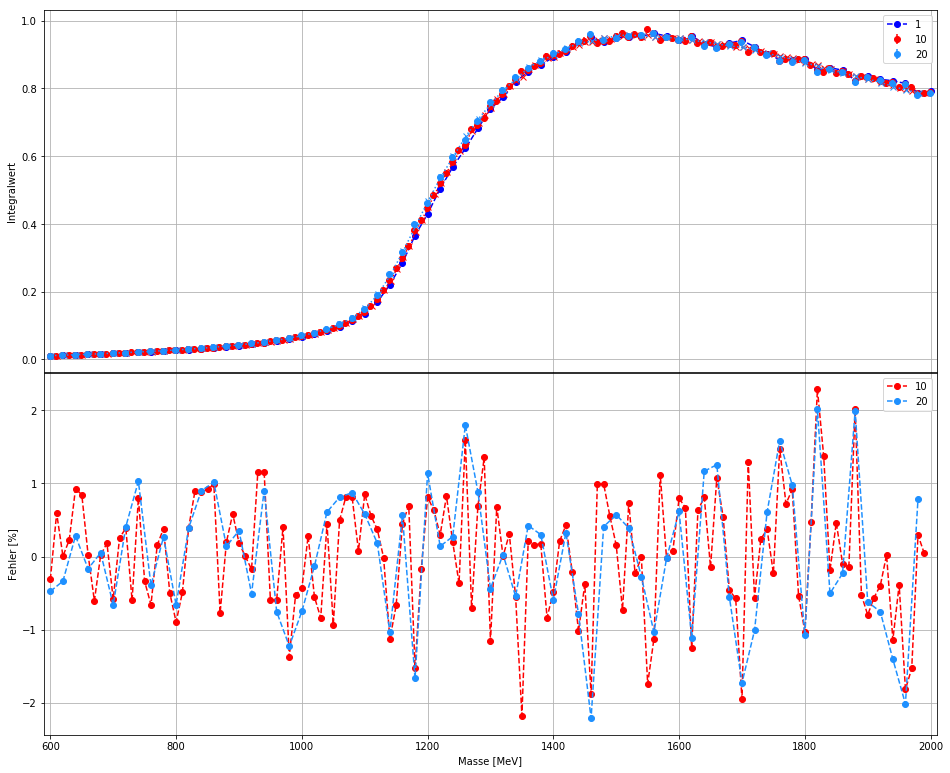

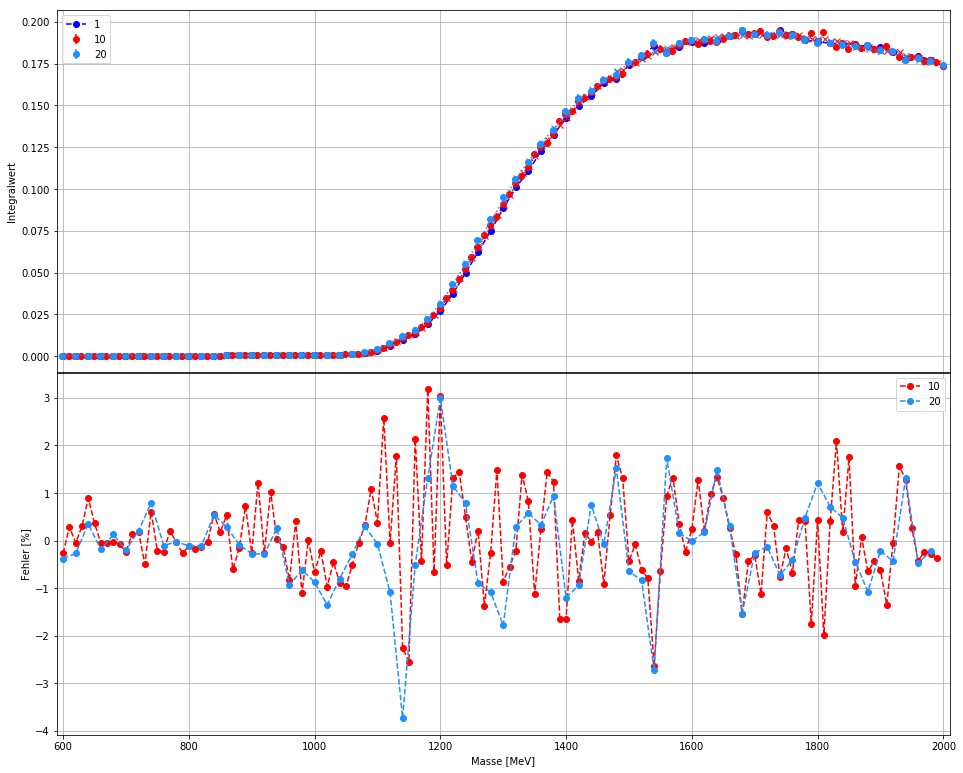

In [54]:
matrix1 = integralMatrix1
matrix10 = integralMatrix10
matrix20 = integralMatrix20


xmin = min(axisArr1)-10; xmax = max(axisArr1)+10
#xmin = 400; xmax = 1900


for i in range(9,10):#len(errorMatrixAbsolut)):
    for j in range(8,9):# i+1):
        print i, j
        print onlyfiles[i]
        print onlyfiles[j]

        f = plt.figure(figsize=(16,20))
        plt.subplots_adjust(hspace=0.001)

        ax1 = plt.subplot(311)
        ax1.grid(True)     
        ax1.set_xlim(xmin, xmax)
        #ax1.set_xticks([])
        ax1.set_ylabel('Integralwert')

        axisArr20Interpoliert, matrix20Interpoliert, matrix20ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr20, matrix1[i,j].real, errorMatrixAbsolut1[i,j].real, 20)
        axisArr10Interpoliert, matrix10Interpoliert, matrix10ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr10, matrix1[i,j].real, errorMatrixAbsolut1[i,j].real, 10)
        
        
        ax1.plot(axisArr1[::20],  matrix1[i][j][::20].real,  'o--', color='blue', label='1')
        ax1.errorbar(axisArr10-1,  matrix10[i][j].real,  marker='o', linestyle='None', yerr = errorMatrixAbsolut10[i,j].real, color='red', label='10')
        ax1.errorbar(axisArr10Interpoliert+1,  matrix10Interpoliert,  marker='x', linestyle=':', yerr = matrix10ErrorAbsolutInterpoliert, color='red');

        ax1.errorbar(axisArr20-1,  matrix20[i,j].real, marker='o', linestyle = 'None', yerr = errorMatrixAbsolut20[i,j].real, color='dodgerblue', label='20')
        ax1.errorbar(axisArr20Interpoliert+1,  matrix20Interpoliert,  marker = 'x', linestyle = ':', yerr = matrix20ErrorAbsolutInterpoliert, color='dodgerblue');
        ax1.legend()



        ax2 = plt.subplot(312, sharex=ax1)
        ax2.grid(True)
        ax2.set_xlim(xmin, xmax)
        ax2.set_xlabel('Masse [MeV]')
        ax2.set_ylabel('Fehler [%]')
        ax2.plot(axisArr10Interpoliert, 100 * (matrix10Interpoliert - matrix10[i,j][:-1].real)/matrix10[i,j][:-1].real, 'o--', color='red', label='10')
        ax2.plot(axisArr20Interpoliert, 100 * (matrix20Interpoliert - matrix20[i,j][:-1].real)/matrix20[i,j][:-1].real, 'o--', color='dodgerblue', label='20')
        ax2.legend()

        xticklabels = ax1.get_xticklabels()
        plt.setp(xticklabels, visible=False)
        #plt.savefig("TK Eigene Plots/SummationBinning/" + str(i) + str(j) + "_Real_" + onlyfiles[i] + "_" + onlyfiles[j] + ".png",bbox_inches='tight')
        plt.show()

        
        if i != j:
            f = plt.figure(figsize=(16,20))
            plt.subplots_adjust(hspace=0.001)

            ax1 = plt.subplot(311)
            ax1.grid(True)     
            ax1.set_xlim(xmin, xmax)
            #ax1.set_xticks([])
            ax1.set_ylabel('Integralwert')

            axisArr20Interpoliert, matrix20Interpoliert, matrix20ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr20, matrix1[i,j].imag, errorMatrixAbsolut1[i,j].imag, 20)
            axisArr10Interpoliert, matrix10Interpoliert, matrix10ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr10, matrix1[i,j].imag, errorMatrixAbsolut1[i,j].imag, 10)

            ax1.plot(axisArr1[::20],  matrix1[i][j][::20].imag,  'o--', color='blue', label='1')
            ax1.errorbar(axisArr10-1,  matrix10[i][j].imag,  marker='o', linestyle='None', yerr = errorMatrixAbsolut10[i,j].imag, color='red', label='10')
            ax1.errorbar(axisArr10Interpoliert+1,  matrix10Interpoliert,  marker='x', linestyle=':', yerr = matrix10ErrorAbsolutInterpoliert, color='red');

            ax1.errorbar(axisArr20-1,  matrix20[i,j].imag, marker='o', linestyle = 'None', yerr = errorMatrixAbsolut20[i,j].imag, color='dodgerblue', label='20')
            ax1.errorbar(axisArr20Interpoliert+1,  matrix20Interpoliert,  marker = 'x', linestyle = ':', yerr = matrix20ErrorAbsolutInterpoliert, color='dodgerblue');
            ax1.legend()



            ax2 = plt.subplot(312, sharex=ax1)
            ax2.grid(True)
            ax2.set_xlim(xmin, xmax)
            ax2.set_xlabel('Masse [MeV]')
            ax2.set_ylabel('Fehler [%]')
            ax2.plot(axisArr10Interpoliert, 100 * (matrix10Interpoliert - matrix10[i,j][:-1].imag)/matrix10[i,j][:-1].imag, 'o--', color='red', label='10')
            ax2.plot(axisArr20Interpoliert, 100 * (matrix20Interpoliert - matrix20[i,j][:-1].imag)/matrix20[i,j][:-1].imag, 'o--', color='dodgerblue', label='20')
            ax2.legend()

            xticklabels = ax1.get_xticklabels()
            plt.setp(xticklabels, visible=False)
            #plt.savefig("TK Eigene Plots/SummationBinning/" + str(i) + str(j) + "_Imag_" + onlyfiles[i] + "_" + onlyfiles[j] + ".png",bbox_inches='tight')
            plt.show()




## Print the Exponent Number
e. g. exaxt Value: 10^5; summed Value: 10^8: 5-8 = -2
### Calculation

In [12]:
matrix20 = integralMatrix20
matrix1 = integralMatrix1
matrix10 = integralMatrix10

errorMatrixAbsolut1 = errorMatrixAbsolut1
errorMatrixAbsolut10 = errorMatrixAbsolut10
errorMatrixAbsolut20 = errorMatrixAbsolut20

nmbWaves = len(errorMatrixAbsolut10)
ratio10MaxReal = np.zeros((nmbWaves, nmbWaves))
ratio20MaxReal = np.zeros((nmbWaves, nmbWaves))
ratio10MinReal = np.zeros((nmbWaves, nmbWaves))
ratio20MinReal = np.zeros((nmbWaves, nmbWaves))
ratio10MaxImag = np.zeros((nmbWaves, nmbWaves))
ratio20MaxImag = np.zeros((nmbWaves, nmbWaves))
ratio10MinImag = np.zeros((nmbWaves, nmbWaves))
ratio20MinImag = np.zeros((nmbWaves, nmbWaves))

for i in range(0,nmbWaves):
    z20Real = np.zeros((nmbWaves,len(axisArr20)-1))
    z10Real = np.zeros((nmbWaves,len(axisArr10)-1))
    z20Imag = np.zeros((nmbWaves,len(axisArr20)-1))
    z10Imag = np.zeros((nmbWaves,len(axisArr10)-1))

    for j in range(0,nmbWaves):
        axisArr20InterpoliertReal, matrix20InterpoliertReal, matrix20ErrorAbsolutInterpoliertReal = calcMatrixFromFineToRough(axisArr20, matrix1[i,j].real, errorMatrixAbsolut1[i,j].real, 20)
        axisArr10InterpoliertReal, matrix10InterpoliertReal, matrix10ErrorAbsolutInterpoliertReal = calcMatrixFromFineToRough(axisArr10, matrix1[i,j].real, errorMatrixAbsolut1[i,j].real, 10)
        axisArr20InterpoliertImag, matrix20InterpoliertImag, matrix20ErrorAbsolutInterpoliertImag = calcMatrixFromFineToRough(axisArr20, matrix1[i,j].imag, errorMatrixAbsolut1[i,j].imag, 20)
        axisArr10InterpoliertImag, matrix10InterpoliertImag, matrix10ErrorAbsolutInterpoliertImag = calcMatrixFromFineToRough(axisArr10, matrix1[i,j].imag, errorMatrixAbsolut1[i,j].imag, 10)
      
        #if i == 25 and j == 26 or i == 26 and j == 25 or i == 26 and j == 27 or i == 27 and j == 26:
            #print "d"
            #continue
            
            
            
        z20Real[j] = np.log10(np.abs(matrix20ErrorAbsolutInterpoliertReal/errorMatrixAbsolut20[i,j][:-1].real))
        z10Real[j] = np.log10(np.abs(matrix10ErrorAbsolutInterpoliertReal/errorMatrixAbsolut10[i,j][:-1].real))
        
        if i != j:
            z20Imag[j] = np.log10(np.abs(matrix20ErrorAbsolutInterpoliertImag/errorMatrixAbsolut20[i,j][:-1].imag))
            z10Imag[j] = np.log10(np.abs(matrix10ErrorAbsolutInterpoliertImag/errorMatrixAbsolut10[i,j][:-1].imag))
        else:
            z20Imag[j].fill(np.nan)
            z10Imag[j].fill(np.nan)
        ratio10MaxReal[i,j] = np.amax(z10Real[j])
        ratio10MaxReal[j,i] = np.amax(z10Real[j])
        ratio20MaxReal[i,j] = np.amax(z20Real[j])
        ratio20MaxReal[j,i] = np.amax(z20Real[j])
        ratio10MinReal[i,j] = np.amin(z10Real[j])
        ratio10MinReal[j,i] = np.amin(z10Real[j])
        ratio20MinReal[i,j] = np.amin(z20Real[j])
        ratio20MinReal[j,i] = np.amin(z20Real[j])
                           
        ratio10MaxImag[i,j] = np.amax(z10Imag[j])
        ratio10MaxImag[j,i] = np.amax(z10Imag[j])
        ratio20MaxImag[i,j] = np.amax(z20Imag[j])
        ratio20MaxImag[j,i] = np.amax(z20Imag[j])
        ratio10MinImag[i,j] = np.amin(z10Imag[j])
        ratio10MinImag[j,i] = np.amin(z10Imag[j])
        ratio20MinImag[i,j] = np.amin(z20Imag[j])
        ratio20MinImag[j,i] = np.amin(z20Imag[j])
            

### Plot

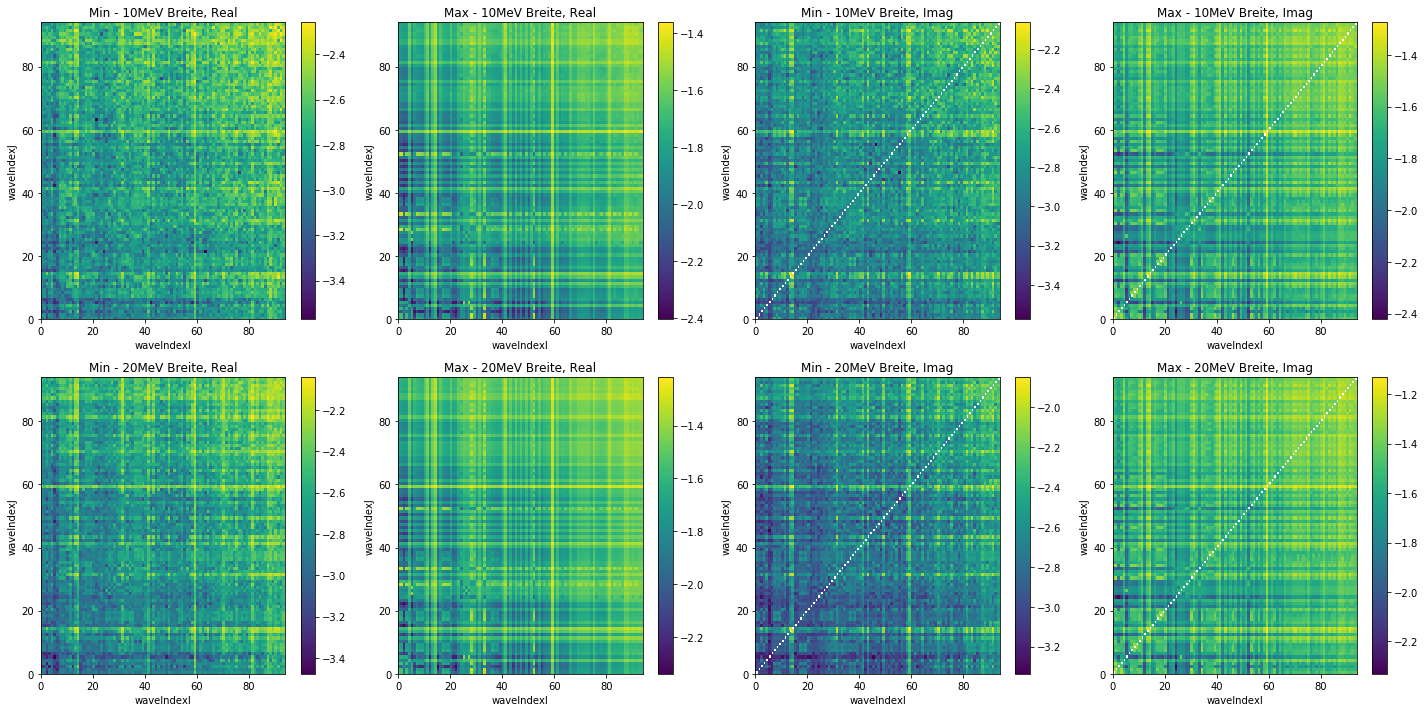

In [76]:
fig = plt.figure(figsize=(20,10))
plt.subplot(2, 4, 1)
plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio10MinReal)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Min - 10MeV Breite, Real")
#plt.show()

plt.subplot(2, 4, 2)
plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio10MaxReal)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Max - 10MeV Breite, Real")
#plt.show()

plt.subplot(2, 4, 3)
plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio10MinImag)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Min - 10MeV Breite, Imag")
#plt.show()

plt.subplot(2, 4, 4)
plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio10MaxImag)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Max - 10MeV Breite, Imag")
#plt.show()

plt.subplot(2, 4, 5)
plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio20MinReal)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Min - 20MeV Breite, Real")
#plt.show()

plt.subplot(2, 4, 6)
plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio20MaxReal)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Max - 20MeV Breite, Real")

plt.subplot(2, 4, 7)
plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio20MinImag)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Min - 20MeV Breite, Imag")
#plt.show()

plt.subplot(2, 4, 8)
plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio20MaxImag)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Max - 20MeV Breite, Imag")
plt.savefig('TK Eigene Plots/FehlerExponent.png')

fig.tight_layout()
plt.show()


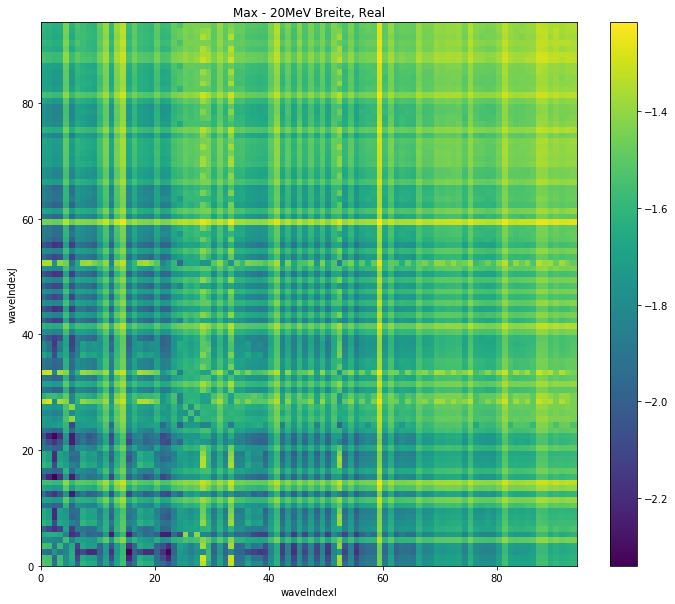

In [29]:
fig = plt.figure(figsize=(12,10))


plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio20MaxReal)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Max - 20MeV Breite, Real")


plt.savefig('TK Eigene Plots/FehlerExponent/Max-20MeV_Breite,_Real.png')
plt.show()


## Print the Relativ Error
### Calculation

In [16]:
def std(arr):
    if isinstance(arr,np.ndarray):
        return np.sqrt(np.sum(arr**2)/len(arr))
    else:
        return 0

In [17]:
matrix1 = integralMatrix1
matrix10 = integralMatrix10
matrix20 = integralMatrix20
nmbWaves = len(errorMatrixAbsolut1)

meanMatrix10 = np.zeros((nmbWaves, nmbWaves), dtype=complex)
meanMatrix20 = np.zeros((nmbWaves, nmbWaves), dtype=complex)

maxMatrix10 = np.zeros((len(errorMatrixAbsolut1), len(errorMatrixAbsolut1)), dtype=complex)
maxMatrix20 = np.zeros((len(errorMatrixAbsolut1), len(errorMatrixAbsolut1)), dtype=complex)

for i in range(0,nmbWaves):#len(errorMatrixAbsolut)):
    for j in range(0, i+1):
        axisArr20Interpoliert, matrix20Interpoliert, matrix20ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr20, matrix1[i,j].real, errorMatrixAbsolut1[i,j].real, 20)
        axisArr10Interpoliert, matrix10Interpoliert, matrix10ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr10, matrix1[i,j].real, errorMatrixAbsolut1[i,j].real, 10)

        errorFitAbsolutReal20 = 100 * (matrix20Interpoliert - matrix20[i,j][:-1].real)/matrix20[i,j][:-1].real
        errorFitAbsolutReal10 = 100 * (matrix10Interpoliert - matrix10[i,j][:-1].real)/matrix10[i,j][:-1].real
         
        if i !=j:
            axisArr20Interpoliert, matrix20Interpoliert, matrix20ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr20, matrix1[i,j].imag, errorMatrixAbsolut1[i,j].imag, 20)
            axisArr10Interpoliert, matrix10Interpoliert, matrix10ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr10, matrix1[i,j].imag, errorMatrixAbsolut1[i,j].imag, 10)          
                        
            errorFitAbsolutImag20 = 100 * (matrix20Interpoliert - matrix20[i,j][:-1].imag)/matrix20[i,j][:-1].imag
            errorFitAbsolutImag10 = 100 * (matrix10Interpoliert - matrix10[i,j][:-1].imag)/matrix10[i,j][:-1].imag
        else:
            errorFitAbsolutImag20 = 0
            errorFitAbsolutImag10 = 0
    
            
        meanMatrix10[i,j] = complex(std(errorFitAbsolutReal10), std(errorFitAbsolutImag10))
        meanMatrix20[i,j] = complex(std(errorFitAbsolutReal20), std(errorFitAbsolutImag20))
        maxMatrix10[i,j]  = complex(np.max(errorFitAbsolutReal10), np.max(errorFitAbsolutImag10))
        maxMatrix20[i,j]  = complex(np.max(errorFitAbsolutReal20), np.max(errorFitAbsolutImag20))
        
        meanMatrix10[j,i] = complex(std(errorFitAbsolutReal10), std(errorFitAbsolutImag10))
        meanMatrix20[j,i] = complex(std(errorFitAbsolutReal20), std(errorFitAbsolutImag20))
        maxMatrix10[j,i]  = complex(np.max(errorFitAbsolutReal10), np.max(errorFitAbsolutImag10))
        maxMatrix20[j,i]  = complex(np.max(errorFitAbsolutReal20), np.max(errorFitAbsolutImag20))

        

        
        
        #print i, j, maxMatrix10[i,j], complex(np.mean(errorFitAbsolutReal10), np.mean(errorFitAbsolutImag10))

### Plot

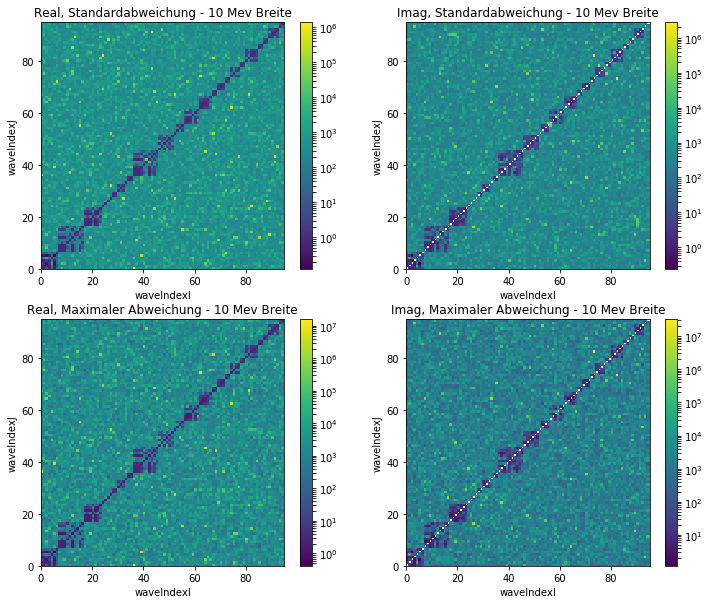

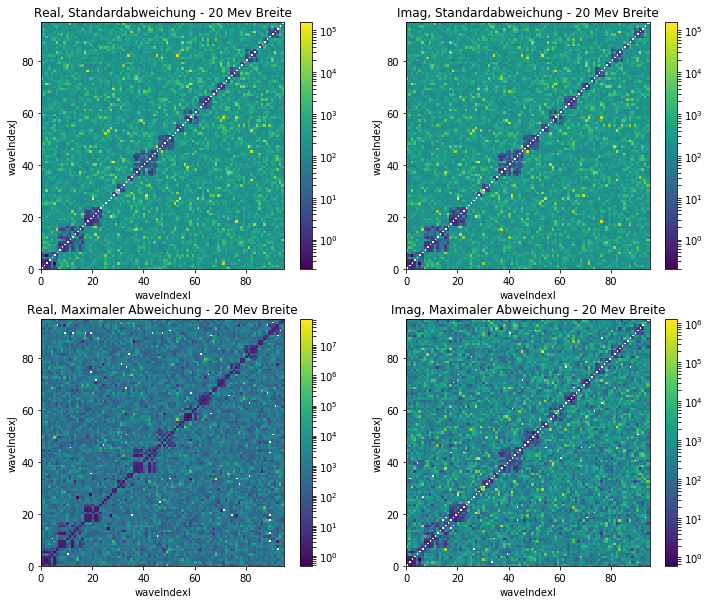

In [18]:

fig = plt.figure(figsize=(12,10))
plt.subplot(2, 2, 1)
plt.pcolormesh(meanMatrix10.real, norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Real, Standardabweichung - 10 Mev Breite")
#plt.show()

plt.subplot(2, 2, 2)
plt.pcolormesh(meanMatrix10.imag, norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Imag, Standardabweichung - 10 Mev Breite")
#plt.show()

plt.subplot(2, 2, 3)
plt.pcolormesh(maxMatrix10.real, norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Real, Maximaler Abweichung - 10 Mev Breite")
#plt.show()

plt.subplot(2, 2, 4)
plt.pcolormesh(maxMatrix10.imag, norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Imag, Maximaler Abweichung - 10 Mev Breite")
plt.show()



fig = plt.figure(figsize=(12,10))
plt.subplot(2, 2, 1)
plt.pcolormesh(meanMatrix20.imag, norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Real, Standardabweichung - 20 Mev Breite")
#plt.show()

plt.subplot(2, 2, 2)
plt.pcolormesh(meanMatrix20.imag, norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Imag, Standardabweichung - 20 Mev Breite")
#plt.show()

plt.subplot(2, 2, 3)
plt.pcolormesh(maxMatrix20.real, norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Real, Maximaler Abweichung - 20 Mev Breite")
#plt.show()

plt.subplot(2, 2, 4)
plt.pcolormesh(maxMatrix20.imag,norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.title("Imag, Maximaler Abweichung - 20 Mev Breite")
plt.show()

# Test

In [ ]:
print meanMatrix10[0,:].real

In [ ]:
print ((errorMatrixAbsolut20[25,26][35:46].real/matrix20ErrorAbsolutInterpoliert.real))
print np.log10(np.abs(((errorMatrixAbsolut20[25,26][35:46].real/matrix20ErrorAbsolutInterpoliert.real))))
print errorMatrixAbsolut20[i,j][35:46].real
print matrix20ErrorAbsolutInterpoliert.real

In [ ]:
# %reset